In [15]:
#Handcrafted ANN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

np.random.seed(1)

In [16]:
df = pd.read_csv('data_banknote_authentication.csv', names=['variance','skewness','curtosis','entropy','class'])
X = np.array( df[['variance','skewness','curtosis','entropy']] )
Y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

X_train = X_train.T
X_test = X_test.T

print(Y.shape)

(1372,)


In [17]:
def sigmoid(Z) : 
    return 1 / (1 + np.exp(-Z))

def relu(Z) : 
    return np.maximum(0, Z)

def d_sigmoid(Z) : 
    gZ = sigmoid(Z)
    return gZ * (1 - gZ)

def d_relu(Z) : 
    return np.where(Z > 0, 1, 0)

def tanh(Z) : 
    return np.tanh(Z)
    
def d_tanh(Z) : 
    return 1 - tanh(Z) ** 2
    
def activate(Z, activation) :
    if activation == 'relu' : return relu(Z)
    elif activation == 'sigmoid' : return sigmoid(Z)
    elif activation == 'tanh' : return tanh(Z)

def d_activate(Z, activation) : 
    if activation == 'relu' : return d_relu(Z)
    elif activation == 'sigmoid' : return d_sigmoid(Z)
    elif activation == 'tanh' : return d_tanh(Z)

In [18]:

class neural_network :  
    
    #initialize parameters 
    def __init__(self, layers, X, Y) :
        self.layers = layers
        self.cache = {}
        self.gradients = {}
        self.parameters = {}
        self.X = X
        self.Y = np.array(Y).reshape(1, Y.shape[0])
        
        layers[0] = (X.shape[0], None)
        self.L = len(layers) - 1
        for i in range(1, len(layers) ) : 
            cur_layer = layers[i][0]
            prev_layer = layers[i-1][0]
            self.parameters['W' + str(i)] = np.random.randn(cur_layer, prev_layer) * .01
            self.parameters['b' + str(i)] = np.zeros((cur_layer, 1))
            
    
    def forward_propagation(self) :   
        Z = self.parameters['W1'].dot(self.X) + self.parameters['b1']
        A = activate(Z, layers[1][1]) 
        self.cache['Z1'] = Z
        self.cache['A1'] = A
        
        for i in range(2, len(self.layers)) : 
            A_prev = A
            Z = self.parameters['W' + str(i)].dot( A_prev ) + self.parameters['b' + str(i)]
            A = activate(Z, layers[i][1]) 
            self.cache['Z' + str(i)] = Z
            self.cache['A' + str(i)] = A


    def cost(self) : 
        A = self.cache['A' + str(self.L)]
        m = self.Y.shape[1]
        cost = - (1/m) * ( np.dot(self.Y, A.T) + np.dot(1 - self.Y, 1 - A.T))
        return np.squeeze(cost)

    
    def backward_propagation(self) :     
        dA = 0
        A = self.cache['A' + str(self.L)]  
        if self.layers[self.L][1] == 'sigmoid' : dA = -( np.divide(self.Y, A) - np.divide(1-self.Y, 1-A) )
        for i in reversed(range(1, self.L + 1)) :
            A_prev = np.array([])
            m = self.X.shape[1]
            if i == 1 : 
                A_prev = self.X
            else : A_prev = self.cache['A' + str(i-1)]
                  
            dZ = dA * d_activate(self.cache['Z' + str(i)], layers[i][1])
            
            dA = np.dot(self.parameters['W' + str(i)].T, dZ)
            
            self.gradients['dW' + str(i)] = (1/m) * dZ.dot(A_prev.T)
            self.gradients['db' + str(i)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
             
                
    def update_parameters(self, alpha) :
        for i in range(1, self.L+1) : 
            self.parameters['W' + str(i)] = self.parameters['W' + str(i)] - alpha * self.gradients['dW' + str(i)]
            self.parameters['b' + str(i)] = self.parameters['b' + str(i)] - alpha * self.gradients['db' + str(i)]
    
    
    def train(self, alpha, iterations, show_cost = False) : 
        costs = []
        for i in range(iterations) : 
            self.forward_propagation()
            cost = self.cost()
            costs.append(cost)
            if show_cost == True and i%1000 == 0 : print(cost)
            self.backward_propagation()
            self.update_parameters(alpha)
        plt.plot(np.arange(0,iterations), costs)
        plt.xlabel('iterations')
        plt.ylabel('cost')
        plt.show()
        
    def predict(self, X_test) : 
        Z = self.parameters['W1'].dot(X_test) + self.parameters['b1']
        A = activate(Z, layers[1][1])  
        for i in range(2, len(self.layers)) : 
            A_prev = A
            Z = self.parameters['W' + str(i)].dot( A_prev ) + self.parameters['b' + str(i)]
            A = activate(Z, layers[i][1]) 
        return np.where(A > .5, 1, 0) 

-0.500000249650308
-0.5068176899445644
-0.8565968640760235
-0.9793938491373969
-0.9916832775700365
-0.9954675258884325


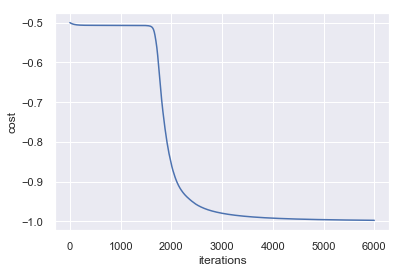

In [25]:
layers = {1: (4, 'relu'), 2: (4, 'relu'), 3: (1, 'sigmoid')}
network = neural_network(layers, X_train, y_train)
network.train(.05, 6000, show_cost=True)


In [26]:
y_hat = network.predict(X_train)
y_hat = y_hat.reshape(y_train.shape[0])
print('train accuracy: ', accuracy_score(y_train, y_hat))

y_hat = network.predict(X_test)
y_hat = y_hat.reshape(y_test.shape[0])
print('test accuracy: ', accuracy_score(y_test, y_hat))
    
print('confusion matrix: \n', confusion_matrix(y_test, y_hat))


train accuracy:  1.0
test accuracy:  1.0
confusion matrix: 
 [[111   0]
 [  0  95]]
